# Exoplanet Transit Classification (Kepler Mission)
## Exploratory Data Analysis: Part I

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from KOIclass import KOIObject

#### Load extracted feature table

In [2]:
feature_df_path = "..\\data\\feat_df_tot.csv"
df_exo = pd.read_csv(feature_df_path, index_col = ['KIC_ID', 'TCE_num'])
df_exo.head(3)

,,Period,Depth,Duration,target_label,even_odd_stat,p_secondary,time_complexity,rms,max,min,...,LCBIN_131,LCBIN_132,LCBIN_133,LCBIN_134,LCBIN_135,LCBIN_136,LCBIN_137,LCBIN_138,LCBIN_139,LCBIN_140
KIC_ID,TCE_num,,,,,,,,,,,,,,,,,,,,,
757450,1,8.884923,16053.4,2.07004,1,0.925362,0.007862,12.181757,0.001264,0.000177,-0.015739,...,0.003811,0.003485,0.004310,0.005135,0.005959,0.006784,0.007609,0.008434,0.009258,0.010083
1026032,1,8.460439,76412.9,4.73492,2,0.978880,0.000000,6.820030,0.008070,0.000360,-0.077604,...,0.001283,0.001274,0.001265,0.001134,0.001003,0.000872,0.000741,0.000870,0.000999,0.001129
1293031,1,0.539366,145.0,5.43400,3,0.499758,0.289257,8.781153,0.000008,0.000026,-0.000017,...,0.417232,0.435126,0.453019,0.470913,0.488807,0.506700,0.524594,0.542487,0.560381,0.578274


Before we start on anything else, let's get a feel for the different representative light curves in each of the classes and why I created some of the features (such as even_odd_stat or p_secondary). Also, we'll give an overview of the steps taken in processing the light curves for the first Kepler object of interest we look at. 

#### KIC 10260032, TCE number 1 corresponds to a secondary eclipse false positive. Let's take a closer look at it.

In [3]:
df_exo.loc[1026032, 1]

,,Period,Depth,Duration,target_label,even_odd_stat,p_secondary,time_complexity,rms,max,min,...,LCBIN_131,LCBIN_132,LCBIN_133,LCBIN_134,LCBIN_135,LCBIN_136,LCBIN_137,LCBIN_138,LCBIN_139,LCBIN_140
KIC_ID,TCE_num,,,,,,,,,,,,,,,,,,,,,
1026032,1,8.460439,76412.9,4.73492,2,0.97888,0.0,6.82003,0.00807,0.00036,-0.077604,...,0.001283,0.001274,0.001265,0.001134,0.001003,0.000872,0.000741,0.00087,0.000999,0.001129


In [4]:
secondary_example1 = KOIObject(1026032, 1).total_initialize()

The Kepler data validation pipeline offers a median detrended, whitened (noise from stellar variability is definitely not white) version of the light curve. The median is extracted from a rolling window that is a few integral numbers of the primary transit duration. The plot below shows the processed relative light flux from the given star as a function of time. Relative flux = 0 is the (now Gaussian noise) baseline of the star. The light curve points below the baseline belong to light curve dips corresponding to transits. 

The structure looks a little complex but eyeballing it one can make out a high degree of periodicity with evidence of an alternating pattern in the light curve. 

In [5]:
# secondary_example1.plot_LC()

In [6]:
secondary_example1.period # period in days

8.460442204901216

We phase fold the light curve on the transit period, bin all points using a bin width that is the average sampling time and average inside the bin. The result is plotted below:

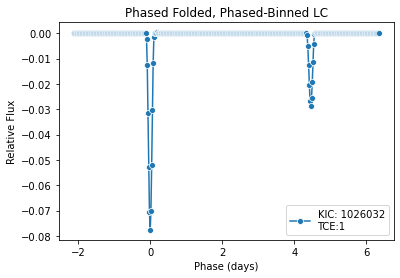

In [7]:
secondary_example1.plot_phasefolded()

The large dip is the primary eclipse/transit. The phase is measured in days and covers an entire period (in this case ~ 8.4 days) referenced to a 0 day phase for the primary transit.

### Type I Secondary Eclipse False Positive Characteristics

#### The phased light curve of a secondary eclipse false positive has a primary transit and a weaker secondary eclipse. The secondary eclipse can be seen pretty clearly in the above phase-folded, bin-averaged light curve. Physically, this type of light curve with a secondary eclipse corresponds to a binary star system (typically of two stars with unequal magnitude) as opposed to a planet. The primary is when the lower luminosity star passes in front of the higher luminosity star (blocking light from the higher luminosity star) while the secondary eclipse is when the lower luminosity star passes behind the higher luminosity star (thus blocking the light from the lower luminosity star).

#### Depending on the orbital parameters and stellar properties of the binary system and our perspective view, the secondary peak can be weaker or stronger than what we observe above. 

#### In order to test whether we have a secondary eclipse or not -- which is a strong indicator of a false positive -- we constructed a simple statistical test for the existence of a secondary. This is done by subtracting the primary peak, finding the lowest valued valley 1 sigma away from the noise floor, and then outputting the probablity that the minimum value of the valley or values more extreme were generated by the noise floor (we assume a Gaussian process with the noise floor mean and std). This probability is stored in the feature matrix as p_secondary. Lower values closer to 0 are more suggestive that the observed dip is a true secondary eclipse.

#### The secondary with the primary subtracted can be seen below, along with left/right base peak supports and the estimated peak location/value:

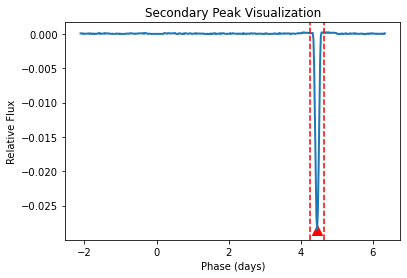

In [8]:
secondary_example1.plot_secondary()

### Type II Secondary Eclipse False Positive

In many cases, the secondary occurs at exactly half period with very similar event duration as the primary. In addition, both secondary and primary eclipses both have high enough amplitude and are registered by statistical event detection / periodogram techniques as just different cycles of the same transit. This leads to a halving of the estimated period with respect to the true period of the binary orbit. Physically, this usually happens for binary stars that are very close to each other and having nearly circular orbits. 

Let's take a look at an example of such a light curve in the Kepler DV pipeline below:

In [9]:
secondary_example2 = KOIObject(3127817, 1).total_initialize()

Plotting the entire light curve there are some indications that there are two different amplitude valley levels in the dips. The Kepler pipeline however logs only one periodic transit crossing based on its initial event detection and periodogram analysis. 

In [10]:
# secondary_example2.plot_LC()

Phase folding and bin-averaging this curve with the period set by the initial event detection superimposes any primary and secondary transit on top of each other and averaging them. The result is below:

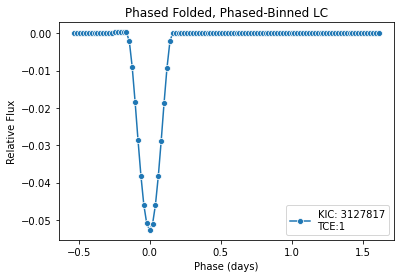

In [11]:
secondary_example2.plot_phasefolded()

In this case, we separate out alternate cycles, phase fold/bin-average each type of cycle (even/odd) amongs its own type, and then stagger the curves by Kepler's estimated period. The result is below:

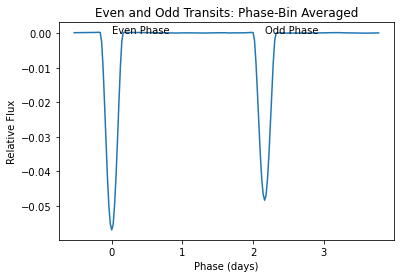

In [12]:
secondary_example2.plot_oddandeven_transit()

The even and odd phase bin-averaged light curves have different amplitudes indicating that one is likely a primary transit and the other a secondary eclipse of a binary star. We need to create a statistical test for whether the odd and even phased transit valley amplitudes are sufficiently different. 

We group all the even-phase valley minima and all the odd-phase valley minima and perform a 2 sample t-test. The feature 'even_odd_stat' is the p-value for testing whether we can reject the null hypothesis that the even and odd phase bin-averaged transits have the same amplitude. In cases where we can reject, this is a sign that we could have an eclipsing binary false positive on our hands.

#### Shape of the transit curve: rescaling + secondary eclipse curve collapse

The secondary signal false positives (often eclipsing binary systems) often have a characteristic V-like shape on the transit dips. We'll see later that this usually differs from the shape of actual exoplanet transits. Now, the idea is that I wanted to be able to compare the shapes of the transits (particularly, zooming in on the primary transit).

 In order to make a meaningful comparison, I selected +-2 transit durations about the primary transit phased at 0. The primary transit close-up was then y-rescaled so that the transit crossing minimum lies at -1, x-rescaled by the transit duration. Then I rebinned to a fixed length series (141 bins), down-sampling or up-sampling/interpolating as necessary. The result for a few secondary false positives is below:

In [13]:
SS_falsepositive_indices = [(12643589,1), (1026032,1), (12644774,1), (2438490,1), (2437783,1), (2446623, 1), (2437488,1), (2438070, 1)]

These are all class 2 (secondary eclipse false positives)

In [14]:
df_exo['target_label'].loc[SS_falsepositive_indices]

KIC_ID    TCE_num
12643589  1          2
1026032   1          2
12644774  1          2
2438490   1          2
2437783   1          2
2446623   1          2
2437488   1          2
2438070   1          2
Name: target_label, dtype: int64

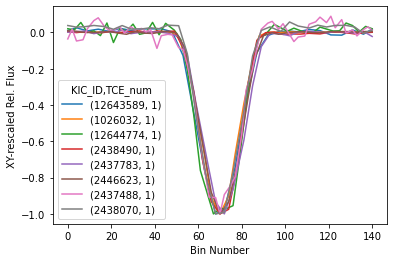

In [15]:
ax = df_exo.loc[(12643589,1),'LCBIN_0':'LCBIN_140'].T.reset_index().plot()
df_exo.loc[(1026032,1),'LCBIN_0':'LCBIN_140'].T.reset_index().plot(ax = ax)
df_exo.loc[(12644774,1),'LCBIN_0':'LCBIN_140'].T.reset_index().plot(ax = ax)
df_exo.loc[(2438490,1),'LCBIN_0':'LCBIN_140'].T.reset_index().plot(ax = ax)
df_exo.loc[(2437783,1),'LCBIN_0':'LCBIN_140'].T.reset_index().plot(ax = ax)
df_exo.loc[(2446623, 1),'LCBIN_0':'LCBIN_140'].T.reset_index().plot(ax = ax)
df_exo.loc[(2437488,1),'LCBIN_0':'LCBIN_140'].T.reset_index().plot(ax = ax)
df_exo.loc[(2438070, 1), 'LCBIN_0':'LCBIN_140'].T.reset_index().plot(ax = ax)
plt.xlabel('Bin Number')
plt.ylabel('XY-rescaled Rel. Flux')
plt.show()


Many of the secondary eclipse light curves collapse onto a single normalized V-shaped curve with this rescaling. Of course, this is ideal. Lower SNR can definitely mess with this and there are some possible planet candidates that have secondary eclipses and different shapes on the transit than the V-shapes seen above.

### Non-Transiting Phenomena False Positives

These can be associated with stars that periodically pulsate, nearby objects periodically polluting the light curve of a given star, etc. These can have rather different light curve signatures/shapes than actual exoplanet transits or binary star systems.

#### Chirp-like periodic light curves

In [16]:
ntp_example1 = KOIObject(3324644, 1).total_initialize()

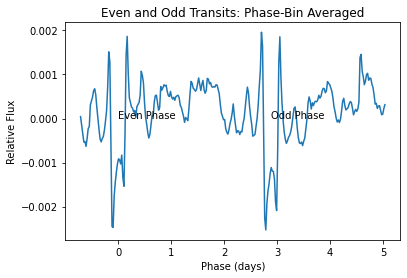

In [17]:
ntp_example1.plot_oddandeven_transit()

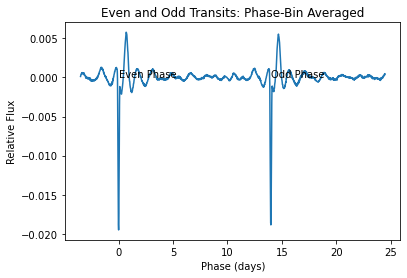

In [18]:
ntp_example2 = KOIObject(4142768, 1).total_initialize()
ntp_example2.plot_oddandeven_transit()

#### Other kinds of oscillatory patterns

In [19]:
ntp_example3 = KOIObject(4729553, 1).total_initialize()
# ntp_example3.plot_LC()

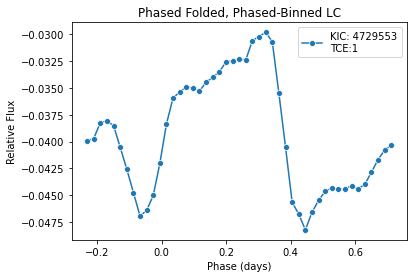

In [20]:
ntp_example3.plot_phasefolded()

#### Junk light curves

In [21]:
ntp_example4 = KOIObject(3650049, 1).total_initialize()

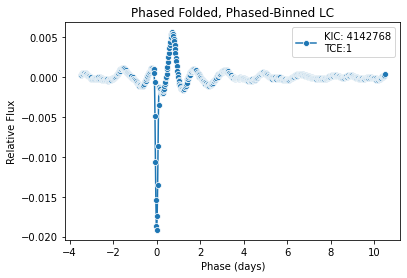

In [22]:
ntp_example2.plot_phasefolded()

#### We've also noticed a few curves in the non transiting false positive that look a lot like secondary eclipse false positives. These could potentially lead to misclassification between the two false positive classes down the road so its good to keep in the back of our head. An example is below:

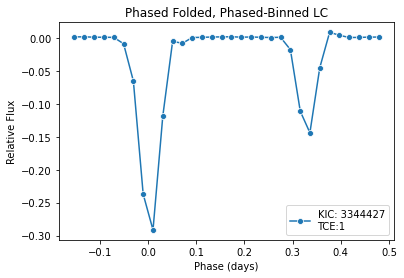

In [23]:
ntp_example5 = KOIObject(3344427,1).total_initialize()
ntp_example5.plot_phasefolded()

### Confirmed Planets

Actual exoplanets exhibit sharp transiting crossing events but there usually is no secondary eclipse event. The absence of a secondary eclipse on a true exoplanet crossing stems from the fact that exoplanets don't generate enough detectable light themselves. Thus when the planet gets shadowed by the star there is no corresponding secondary dip (or it is extremely weak). 


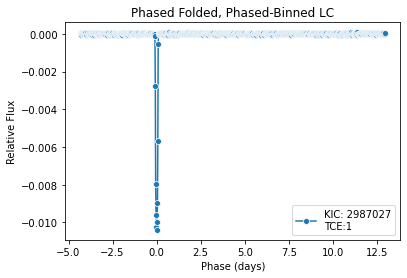

In [156]:
cp_example = KOIObject(2987027,1).total_initialize()
cp_example.plot_phasefolded()

True exoplanet transits often have a slightly different transit shape. The transit more approximates a U rather than a V-shape. The difference in shape is related to the size of the exoplanet vs a binary companion, typical orbital parameters (planets usually being much closer to the star than neighboring stars), and exoplanet light curve transits being sensitive to the light intensity profile of the star (edges of the star present darker than the center -- leading to an effect called limb darkening). Limb darkening also contributes to the shape of true exoplanet transits. 

A close-up of a typical high SNR exoplanet TCE along with an L2 trend-filter smoothed approximation is seen below:

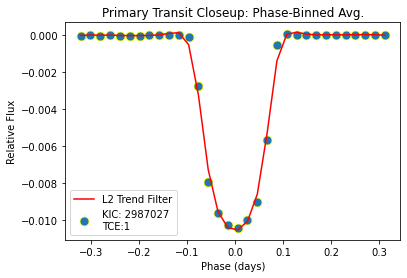

In [157]:
cp_example.plot_transit_closeup()

The hope is that we can use the xy-rescaled and rebinned transit closeups to help distinguish between binaries and confirmed planets. A few of the xy-rescaled transit close-ups for the  confirmed planets are plotted below. Again, just like the secondary eclipse false positives, the curves tend to collapse onto each other. The shape, however, is a little different and is more of a U-shape thean a V-shape. 

<AxesSubplot:>

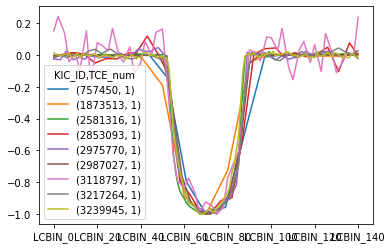

In [39]:
CP_df = df_exo.loc[(df_exo.target_label == 1) & (df_exo.Depth > 2000)].head(9)
CP_df.loc[:, 'LCBIN_0':'LCBIN_140'].T.plot()

A comparison of high SNR examples in the confirmed planet (orange) and secondary false positve classes (blue) clarifies the shape distincion.

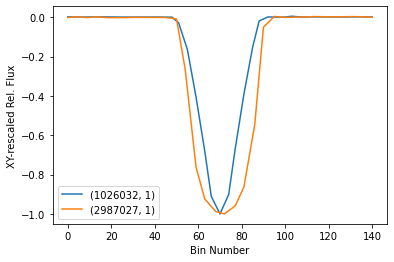

In [150]:
ax2 = df_exo.loc[(1026032,1),'LCBIN_0':'LCBIN_140'].T.reset_index().plot()
df_exo.loc[(2987027,1),'LCBIN_0':'LCBIN_140'].T.reset_index().plot(ax = ax2)
plt.xlabel('Bin Number')
plt.ylabel('XY-rescaled Rel. Flux')
plt.legend()
plt.show()

Low SNR, etc, can really blur this distinction by shape -- especially as the U and V shapes are not too dissimilar to each other.  Hopefully these xy-normalized transit closeups will be of decent aid in secondary FP and confirmed planet distinction. The hope is that they really shine when it comes to separating out non-transiting phenomena which have very different shapes than class 2 and 3.